In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

## 1. Load data

In [3]:
file = 'data_banknote_authentication.txt'
data = pd.read_csv(file, header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
data

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Class 1 is fake banknote, and class 0 is true banknote.

## 2. Data Exploration

In [4]:
data.isnull().sum()

variance    0
skewness    0
curtosis    0
entropy     0
class       0
dtype: int64

Great that we do not have null values :)

In [5]:
num_fake = data['class'].sum()
ratio_fake = num_fake/len(data)

print("Number of fake banknotes:", num_fake)
print("Percentage of fake banknotes:", ratio_fake)

Number of fake banknotes: 610
Percentage of fake banknotes: 0.4446064139941691


Among the 1372 banknotes, 610 are fake banknotes. The dataset is balanced in true and fake banknotes.

In [6]:
# conclusion statistics of fake banknotes
data[data['class'] == 1].describe()

,variance,skewness,curtosis,entropy,class
count,610.000000,610.000000,610.000000,610.000000,610.0
mean,-1.868443,-0.993576,2.148271,-1.246641,1.0
std,1.881183,5.404884,5.261811,2.070984,0.0
min,-7.042100,-13.773100,-5.286100,-7.588700,1.0
25%,-3.061450,-5.810025,-1.357500,-2.458375,1.0
50%,-1.806100,0.172775,0.373720,-0.661650,1.0
75%,-0.541770,3.189275,5.626350,0.341790,1.0
max,2.391700,9.601400,17.927400,2.135300,1.0


In [7]:
# conclusion statistics of true banknotes
data[data['class'] == 0].describe()

,variance,skewness,curtosis,entropy,class
count,762.000000,762.000000,762.000000,762.000000,762.0
mean,2.276686,4.256627,0.796718,-1.147640,0.0
std,2.019348,5.138792,3.239894,2.125077,0.0
min,-4.285900,-6.932100,-4.941700,-8.548200,0.0
25%,0.883345,0.450063,-1.709700,-2.228250,0.0
50%,2.553100,5.668800,0.700605,-0.552380,0.0
75%,3.884450,8.691975,2.652925,0.423257,0.0
max,6.824800,12.951600,8.829400,2.449500,0.0


Although we can see some trends in the description tables, like fake banknotes have lower `variance`, it is actually difficult to see a clear difference between true and fake banknotes among these four features, `variance`, `skewness`, `curtosis`, and `entropy`.

It is better to visualize the distribution of these four features.

#### 2.1 Visualization

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
def FeatureDistribution(feature):
    fig = plt.figure(figsize=(8,3.5))
    sns.kdeplot(data.loc[data['class'] == 1, feature], color='r', shade=True, label="Fake")
    sns.kdeplot(data.loc[data['class'] == 0, feature], color='b', shade=True, label="True",)
    plt.xlabel(feature)
    plt.ylabel('kernel density')
    plt.legend()
    #plt.savefig("figures/{}_dist.png".format(feature), bbox_inches='tight')
    plt.show()

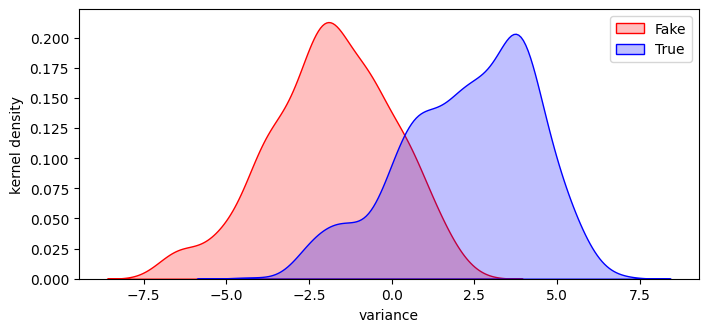

In [10]:
FeatureDistribution('variance')

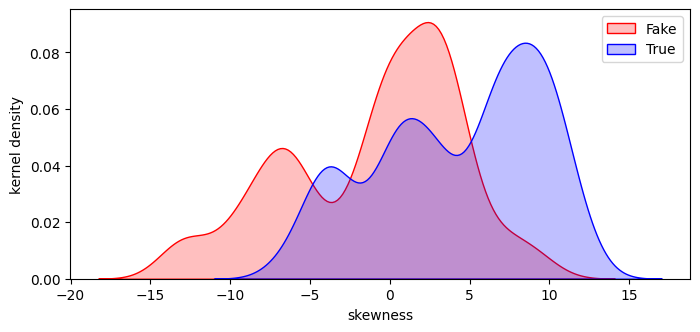

In [11]:
FeatureDistribution('skewness')

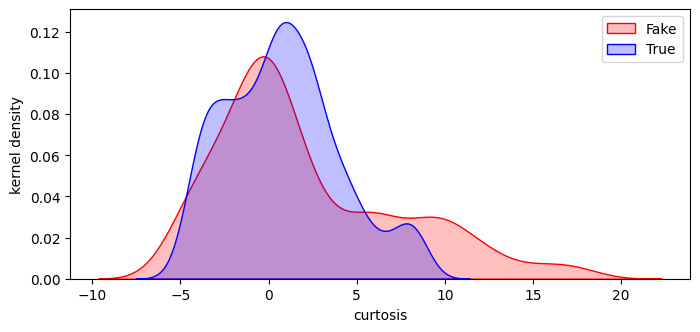

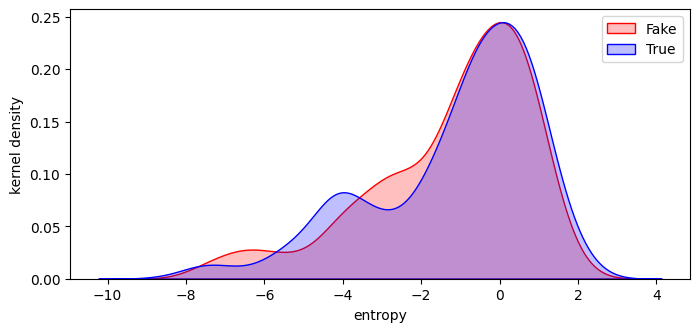

In [12]:
FeatureDistribution('curtosis')
FeatureDistribution('entropy')

- Among the four features, only `variance` and `skewness` show relatively clear difference in distribution between true and fake banknotes, though there are still overlaps.

- True and fake banknotes overlap with each other almost completely in `curtosis` and `entropy`.

#### 2.2 Feature correlation

In [13]:
corr = data.corr()
corr

,variance,skewness,curtosis,entropy,class
variance,1.000000,0.264026,-0.380850,0.276817,-0.724843
skewness,0.264026,1.000000,-0.786895,-0.526321,-0.444688
curtosis,-0.380850,-0.786895,1.000000,0.318841,0.155883
entropy,0.276817,-0.526321,0.318841,1.000000,-0.023424
class,-0.724843,-0.444688,0.155883,-0.023424,1.000000


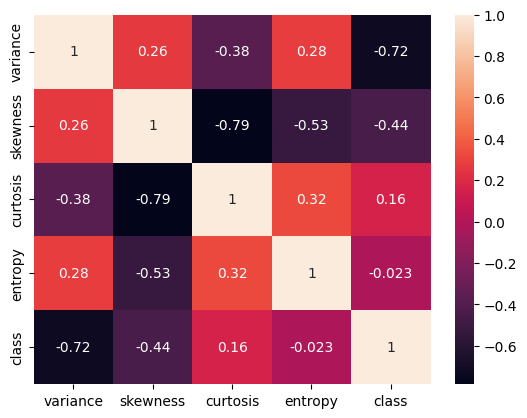

In [14]:
sns.heatmap(data.corr(), xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.show()

- `class` (true or fake banknotes) has strong correlations with `variance` and `skewness`. The correlation between `class` and `curtosis` is also non-negligible.
  
- There might be latent correlation between `class` and `entropy`, as `entropy` have sustantial correlations with `variance`, `skewness`, and `curtosis`.

#### 2.3 Statistical examination

Now we use hypothesis tests to rigorously decide which features to use in the logistic regression model. Since all the features are numerical, we only use Kolmogorov–Smirnov test (***K-S test***).

In [15]:
from scipy.stats import ks_2samp

def KS_test(feature):

    dist_true = data.loc[data['class']==0][feature]
    dist_fake = data.loc[data['class']==1][feature]
    __, p_value = ks_2samp(dist_true,dist_fake)
    print(feature + ' p-value: {}'.format(p_value))

In [16]:
KS_test('variance')
KS_test('skewness')
KS_test('curtosis')
KS_test('entropy')

variance p-value: 1.708016779480064e-165
skewness p-value: 3.466881810901478e-64
curtosis p-value: 2.093929045695565e-09
entropy p-value: 0.333460928017807


As expected, `variance`, `skewness`, and `curtosis` have p-values < 0.05. For these three features, we reject the null hypothesis that they have same distribution between true and fake banknotes. We will further use them in model training.

## 3. Logistic regression

Logistic regression is an easy and most common method to do binary classification. Compared to other classification methods/models, logistic regression is also faster and more straight-forward. I will evaluate the classification performance with true-positive rate (TPR) and false-positive rate (FPR).

#### 3.1 Model training preparation 

Based on the K-S test, we drop `entropy` and use only `variance`, `skewness`, and `curtosis`.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LogisticRegression

In [18]:
data_feature = data.drop(['entropy'], axis=1)
data_feature.head()

,variance,skewness,curtosis,class
0,3.62160,8.6661,-2.8073,0
1,4.54590,8.1674,-2.4586,0
2,3.86600,-2.6383,1.9242,0
3,3.45660,9.5228,-4.0112,0
4,0.32924,-4.4552,4.5718,0


We also need to standardize/normalize the data to ensure the efficiency and quality of the modelling.

In [19]:
x_features = data_feature.drop(['class'], axis=1)
y_label = data_feature['class'].values

# Standardize/normalization
scaler = StandardScaler()
x_features_scaled = pd.DataFrame(scaler.fit_transform(x_features), columns=x_features.columns)

In [20]:
# Split into training and test sets
x_train, x_test, y_train, y_test =  train_test_split(x_features_scaled, y_label, test_size=0.3, random_state=0)

#### 3.2 Model training and hyperparameters tuning/optimizing

The model training and tuning will be evaluated by the Area Under the Receiver Operating Characteristic Curve (**ROC AUC**), a relation between TPR and FPR. ***ROC AUC score is between 0 and 1, the closer to 1 the better the classification.***

We ***optimize/tune the hyperparameters with grid search.***

In [21]:
# Training model and tuning hyperparameters
lr_three_feature = LogisticRegression()

C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

grid_search = GridSearchCV(estimator=lr_three_feature,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search_result = grid_search.fit(x_train, y_train)

print("Best ROC AUC score:", grid_search_result.best_score_)
print("Optimized value of C:", grid_search_result.best_params_)

Best ROC AUC score: 0.9997367266344888
Optimized value of C: {'C': 0.5754399373371573}


In [22]:
# Get the optimized model for evaluation
lr_three_feature_optimized = grid_search_result.best_estimator_

#### 3.3 Performance evaluation

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score

def PerformanceReport(optimized_model, x_train, x_test, y_train, y_test):
    y_train_predict = optimized_model.predict(x_train)
    y_train_predict_prob = optimized_model.predict_proba(x_train)[:, 1] 

    y_test_predict = optimized_model.predict(x_test)
    y_test_predict_prob = optimized_model.predict_proba(x_test)[:, 1]

    train_confusion_mat = confusion_matrix(y_train, y_train_predict)
    test_confusion_mat = confusion_matrix(y_test, y_test_predict)

    train_tn, train_fp, train_fn, train_tp = train_confusion_mat.ravel()
    test_tn, test_fp, test_fn, test_tp = test_confusion_mat.ravel()

    print('Training true positive:', train_tp)
    print('Training false positive:', train_fp)
    print('Training true negative:', train_tn)
    print('Training false negative:', train_fn)
    print('\n')
    print('Test true positive:', test_tp)
    print('Test false positive:', test_fp)
    print('Test true negative:', test_tn)
    print('Test false negative:', test_fn)
    
    print('\n')
    print('=======')
    print('ROC AUC score of training set:', roc_auc_score(y_train, y_train_predict_prob))
    print('ROC AUC score of test set:', roc_auc_score(y_test, y_test_predict_prob))
    print('=======')
    print('Classification accuracy of training set:', accuracy_score(y_train, y_train_predict))
    print('Classification accuracy of test set:', accuracy_score(y_test, y_test_predict))
    print('=======')
    print('Classification precision of training set:', precision_score(y_train, y_train_predict))
    print('Classification precision of test set:', precision_score(y_test, y_test_predict))
    print('=======')
    print('Classification recall of training set:', recall_score(y_train, y_train_predict))
    print('Classification recall of test set:', recall_score(y_test, y_test_predict))
    print('=======')
    print('Classification f1 score of training set:', f1_score(y_train, y_train_predict))
    print('Classification f1 score of test set:', f1_score(y_test, y_test_predict))

def PlotROC(optimized_model, x_test, y_test):
    y_test_predict_prob = optimized_model.predict_proba(x_test)[:, 1]
    fpr_test, tpr_test, thresh_test = roc_curve(y_test, y_test_predict_prob)
    test_roc_auc = roc_auc_score(y_test, y_test_predict_prob)

    fig = plt.figure()
    plt.plot(fpr_test, tpr_test, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color='b', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Area = {:.2f})'.format(test_roc_auc))
    #plt.savefig('figures/ROCurve.png', bbox_inches='tight')
    plt.show()

In [24]:
PerformanceReport(lr_three_feature_optimized, x_train, x_test, y_train, y_test)

Training true positive: 428
Training false positive: 16
Training true negative: 514
Training false negative: 2


Test true positive: 180
Test false positive: 7
Test true negative: 225
Test false negative: 0


ROC AUC score of training set: 0.9995831505046073
ROC AUC score of test set: 0.9998084291187739
Classification accuracy of training set: 0.98125
Classification accuracy of test set: 0.9830097087378641
Classification precision of training set: 0.963963963963964
Classification precision of test set: 0.9625668449197861
Classification recall of training set: 0.9953488372093023
Classification recall of test set: 1.0
Classification f1 score of training set: 0.9794050343249427
Classification f1 score of test set: 0.9809264305177112


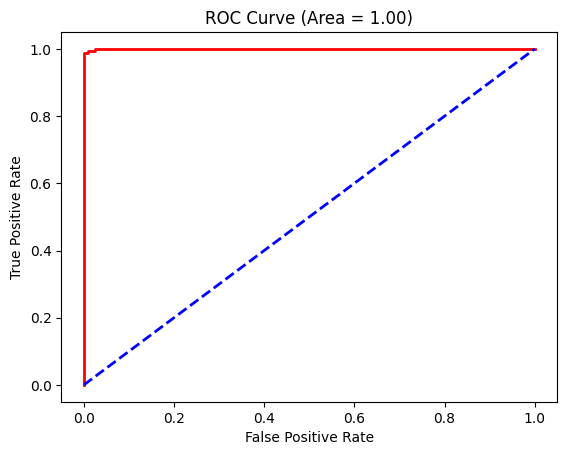

In [26]:
PlotROC(lr_three_feature_optimized, x_test, y_test)

This logistic regression model works extremely well! The ROC AUC score is nearlly 1. We have 98% accuracy with 100% recall. In other words, with this logistic regression model, though the store might receive complaints sometimes from customers who get their banknotes rejected, the store will not lose money due to fake banknotes.

***Your shop will get more five-star reviews!*** 

### Extra: including `entropy`

In [28]:
x_features = data.drop(['class'], axis=1)
y_label = data['class'].values

scaler = StandardScaler()
x_features_scaled = pd.DataFrame(scaler.fit_transform(x_features), columns=x_features.columns)

x_train, x_test, y_train, y_test =  train_test_split(x_features_scaled, y_label, test_size=0.3, random_state=0)

In [29]:
lr_total = LogisticRegression()

C_grid = 0.001*10**(np.arange(0, 1.01, 0.01)*3)
parameters = {"C": C_grid}

grid_search = GridSearchCV(estimator=lr_total,
                           param_grid=parameters,
                           scoring='roc_auc', 
                           n_jobs=-1)

grid_search_result = grid_search.fit(x_train, y_train)

print("Best ROC AUC score:", grid_search_result.best_score_)
print("Optimized value of C:", grid_search_result.best_params_)

Best ROC AUC score: 0.999692847740237
Optimized value of C: {'C': 1.0}


The same as using only three features.

In [30]:
lr_total_optimized = grid_search_result.best_estimator_

In [31]:
PerformanceReport(lr_total_optimized, x_train, x_test, y_train, y_test)

Training true positive: 428
Training false positive: 16
Training true negative: 514
Training false negative: 2


Test true positive: 180
Test false positive: 7
Test true negative: 225
Test false negative: 0


ROC AUC score of training set: 0.9996182536200088
ROC AUC score of test set: 0.9998563218390805
Classification accuracy of training set: 0.98125
Classification accuracy of test set: 0.9830097087378641
Classification precision of training set: 0.963963963963964
Classification precision of test set: 0.9625668449197861
Classification recall of training set: 0.9953488372093023
Classification recall of test set: 1.0
Classification f1 score of training set: 0.9794050343249427
Classification f1 score of test set: 0.9809264305177112


Exactly the same as using three features...

***Entropy is a redundant feature in the true/fake banknote classification*** 